# Coordinates

In structural dynamics, bookkeeping is an incredibly important part of analyzing test or analysis data.  Due to the prevelance of linear algebra operations, we often work with matrices where each row might represent a different measurement or analysis degree of freedom.  If we mix up which row represents which channel, then the results of our analysis will be incorrect.  Therefore, SDynPy labels its data objects with Coordinates, or degrees of freedom.

This document will describe how coordinates are defined and used in SDynPy.  We will start by showing how we can define coordinates, and then walk through the different use-cases in SDynPy.

Let's import SDynPy and start looking at Coordinates!

In [1]:
import sdynpy as sdpy
import numpy as np

## SDynPy Coordinate Objects

 - ``X+`` - The positive $X$ direction
 - ``X-`` - The negative $X$ direction
 - ``Y+`` - The positive $Y$ direction
 - ``Y-`` - The negative $Y$ direction
 - ``Z+`` - The positive $Z$ direction
 - ``Z-`` - The negative $Z$ direction
 - ``RX+`` - A rotation about the positive $X$ direction
 - ``RX-`` - A rotation about the negative $X$ direction
 - ``RY+`` - A rotation about the positive $Y$ direction
 - ``RY-`` - A rotation about the negative $Y$ direction
 - ``RZ+`` - A rotation about the positive $Z$ direction
 - ``RZ-`` - A rotation about the negative $Z$ direction
 - (empty) - No direction

The empty direction is often used to represent what might be described as "scalar" degrees of freedom, for example a modal degree of freedom in a modal model, or a fixed-base modal degree of freedom in a Craig-Bampton substructure.  This could also be used data from microphones or thermocouples which is not associated with a particular direction.

## Creating Coordinates from Scratch

In [2]:
coords = sdpy.coordinate_array(
    node = 10,
    direction = 'Z-')

In [3]:
coords.fields

('node', 'direction')

In [4]:
coords.dtype

dtype([('node', '<u8'), ('direction', 'i1')])

We can see that the node information is stored as an unsigned integer (an integer >= 0), and the direction field is also stored as an integer, though only an 8-bit integer.  SDynPy encodes direction information as integers with the following scheme:

- $X+ = 1$
- $X- = -1$
- $Y+ = 2$
- $Y- = -2$
- $Z+ = 3$
- $Z- = -3$
- $RX+ = 4$
- $RX- = -4$
- $RY+ = 5$
- $RY- = -5$
- $RZ+ = 6$
- $RZ- = -6$
- (empty) $= 0$

In [5]:
coords = sdpy.coordinate_array(
    node = [1,1,1,2,2,2],
    direction = ['X+','Y-','Z-','Y+','X-','Z+'])

In [6]:
coords

coordinate_array(string_array=
array(['1X+', '1Y-', '1Z-', '2Y+', '2X-', '2Z+'], dtype='<U3'))

The ``direction`` argument can also be passed integer values per the encoding.  This can be more compact (no strings required, the five typed characters of `'RX+'` becomes one character ``4``), but less explicit.

In [7]:
coords = sdpy.coordinate_array(
    node = [1,1,1,2,2,2],
    direction = [1,-2,-3,2,-1,3])
coords

coordinate_array(string_array=
array(['1X+', '1Y-', '1Z-', '2Y+', '2X-', '2Z+'], dtype='<U3'))

Note that if the ``node`` and ``direction`` arguments are not the same sizes, a broadcast will be attempted using the usual NumPy broadcasting rules.  For example, if we wanted all ``['X+','Y+','Z+']`` directions for all the nodes between one and ten, we could do something like this:

In [8]:
coords = sdpy.coordinate_array(
    node = (np.arange(10)+1)[:,np.newaxis],
    direction = [1,2,3])
coords

coordinate_array(string_array=
array([['1X+', '1Y+', '1Z+'],
       ['2X+', '2Y+', '2Z+'],
       ['3X+', '3Y+', '3Z+'],
       ['4X+', '4Y+', '4Z+'],
       ['5X+', '5Y+', '5Z+'],
       ['6X+', '6Y+', '6Z+'],
       ['7X+', '7Y+', '7Z+'],
       ['8X+', '8Y+', '8Z+'],
       ['9X+', '9Y+', '9Z+'],
       ['10X+', '10Y+', '10Z+']], dtype='<U4'))

In the previous, we use ``np.arange`` to create a list of numbers from 0-9 to which we add 1, which makes an array from 1 to 10.  Adding the ``np.newaxis`` in the second indexing position creates a new axis at that location, transforming the shape ``(10,)`` array into a shape ``(10,1)`` array.  This can then be broadcast with the shape ``(3,)`` direction array, with the last dimension of the ``node`` array being expanded from length 1 to length 3, and the implicit length-1 dimension of the direction array being expanded to length 10.  This then results in a shape ``(10,3)`` coordinate array.

In [9]:
coords.shape

(10, 3)

For a full treatment of NumPy's broadcasting rules, see the [relevant NumPy documentation](https://numpy.org/doc/stable/user/basics.broadcasting.html).

Obviously, if the broadcasted arrays are not compatible, an error will be thrown.

In [10]:
coords = sdpy.coordinate_array(
    node = (np.arange(10)+1), # No np.newaxis, so arrays are incompatible
    direction = [1,2,3])
coords

ValueError: node and direction should be broadcastable to the same shape (node: (10,), direction: (3,))

If the user doesn't understand or can't be bothered to learn about broadcasting in NumPy, they can provide the ``force_broadcast`` argument to force SDynPy to make it work.  Note that all shape information will be lost as the input arrays will be flattened upon input to force the broadcasting to work.  The author would however implore the user to reconsider and put forth the effort to learn how to broadcast arrays, as it can lead to very elegant handling of multidimensional arrays.

In [11]:
coords = sdpy.coordinate_array(
    node = (np.arange(10)+1), # No np.newaxis, so arrays are incompatible
    direction = [1,2,3],
    force_broadcast=True) # Tell SDynPy you don't care if the arrays are incompatible
coords

coordinate_array(string_array=
array(['1X+', '1Y+', '1Z+', '2X+', '2Y+', '2Z+', '3X+', '3Y+', '3Z+',
       '4X+', '4Y+', '4Z+', '5X+', '5Y+', '5Z+', '6X+', '6Y+', '6Z+',
       '7X+', '7Y+', '7Z+', '8X+', '8Y+', '8Z+', '9X+', '9Y+', '9Z+',
       '10X+', '10Y+', '10Z+'], dtype='<U4'))

In [12]:
# This will throw an error
coords = sdpy.coordinate_array(['1X+','2Z-'])

ValueError: invalid literal for int() with base 10: np.str_('1X+')

In [13]:
coords = sdpy.coordinate_array(string_array = ['1X+','2Z-'])
coords

coordinate_array(string_array=
array(['1X+', '2Z-'], dtype='<U3'))

## Referencing Coordinates to Geometries

In [14]:
geometry = sdpy.geometry.load('geometry.npz')

In [15]:
coords = sdpy.coordinate_array(string_array=['102Z+','204X+'])
geometry.plot_coordinate(coords, label_dofs=True, arrow_scale = 0.1)

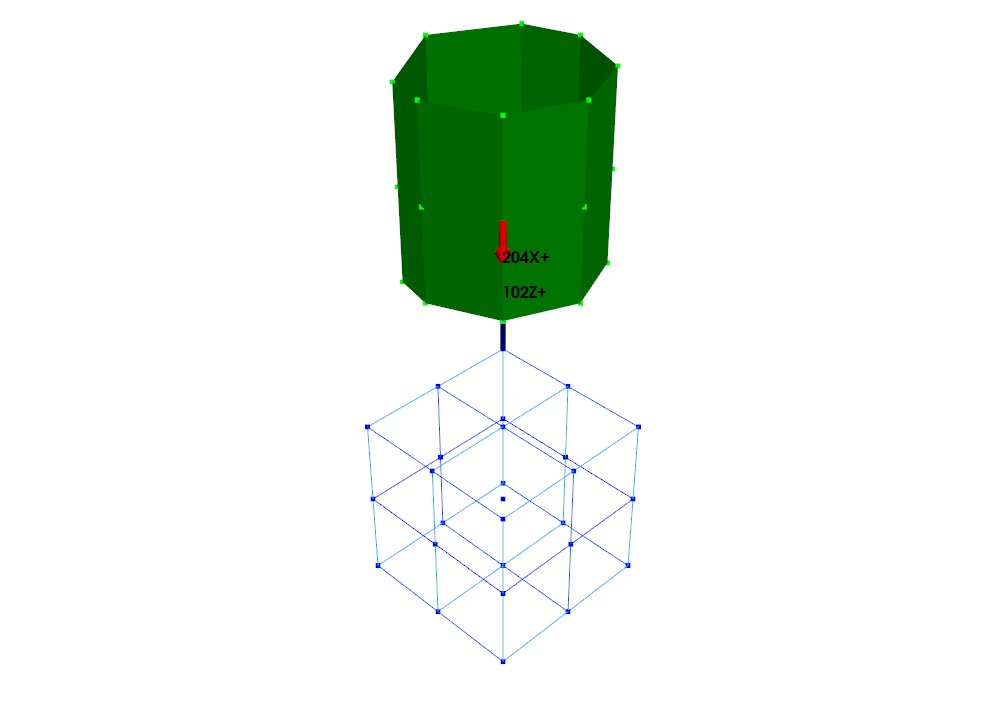

This method allows us to very quickly see where a specific degree of freedom came from on the geometry.

## Set Operations with CoordinateArrays

### Unique Coordinates

One common operation is to get just the unique set of coordinates from a test or an analysis.  One might have duplicated coordinates if combining several datasets together.  NumPy's ``unique`` function will give us just the unique degrees of freedom.

In [16]:
coords = sdpy.coordinate_array([1,3,1,4],['X+','Y+','X+','Z+'])
coords

coordinate_array(string_array=
array(['1X+', '3Y+', '1X+', '4Z+'], dtype='<U3'))

In [17]:
unique_coords = np.unique(coords)
unique_coords

coordinate_array(string_array=
array(['1X+', '3Y+', '4Z+'], dtype='<U3'))

### Finding Coordinates in a Second Coordinate Array

A second common operation is to check which degrees of freedom from a test are in some master list of degrees of freedom.  For this we can use NumPy's ``isin`` function.  This will give a logical array with ``True`` values wherever a degree of freedom was found in the master list.

In [18]:
check_dofs = sdpy.coordinate_array([1,2,3,4],['X+','Y+','Z+'],force_broadcast=True)
check_dofs

coordinate_array(string_array=
array(['1X+', '1Y+', '1Z+', '2X+', '2Y+', '2Z+', '3X+', '3Y+', '3Z+',
       '4X+', '4Y+', '4Z+'], dtype='<U3'))

In [19]:
dofs_to_keep = sdpy.coordinate_array(string_array = ['1X+','2Z+','4Y+'])
dofs_to_keep

coordinate_array(string_array=
array(['1X+', '2Z+', '4Y+'], dtype='<U3'))

In [20]:
keep_indices = np.isin(check_dofs,dofs_to_keep)
keep_indices

array([ True, False, False, False, False,  True, False, False, False,
       False,  True, False])

### Finding Common Coordinates Between Two Datasets

One common operation is to get the common degrees of freedom between two datasets.  Perhaps we are comparing test data to analysis, or two analyses with different modeling assumptions.  We can only compare equivalent degrees of freedom, so we would like to know which degrees of freedom the two sets have in common.

In [21]:
coords_1 = sdpy.coordinate_array([1,2,3,4],['X+','Y-','X+','Z+'])
coords_2 = sdpy.coordinate_array([1,2,4],['X+','Y+','Z+'])

We can use NumPy's ``intersect1d`` function to get the intersection of the two sets of degrees of freedom.

In [22]:
common_dofs = np.intersect1d(coords_1,coords_2)
common_dofs

coordinate_array(string_array=
array(['1X+', '4Z+'], dtype='<U3'))

In [23]:
common_dofs_ignore_polarity = np.intersect1d(abs(coords_1),abs(coords_2))
common_dofs_ignore_polarity

coordinate_array(string_array=
array(['1X+', '2Y+', '4Z+'], dtype='<U3'))

### Excluding Coordinates from a CoordinateArray

In [24]:
coords_1

coordinate_array(string_array=
array(['1X+', '2Y-', '3X+', '4Z+'], dtype='<U3'))

In [25]:
coords_2

coordinate_array(string_array=
array(['1X+', '2Y+', '4Z+'], dtype='<U3'))

In [26]:
remaining_coords = np.setdiff1d(coords_1,coords_2)
remaining_coords

coordinate_array(string_array=
array(['2Y-', '3X+'], dtype='<U3'))

Again, we could take the absolute value to ignore polarity.

In [27]:
remaining_coords_ignore_polarity = np.setdiff1d(
    abs(coords_1),
    abs(coords_2))
remaining_coords_ignore_polarity

coordinate_array(string_array=
array(['3X+'], dtype='<U3'))

### Finding All Coordinates in Two CoordinateArrays

In [28]:
coords_1 = sdpy.coordinate_array(string_array = [
    '1X+','2Y+','3Z+','4RX+'])
coords_1

coordinate_array(string_array=
array(['1X+', '2Y+', '3Z+', '4RX+'], dtype='<U4'))

In [29]:
coords_2 = sdpy.coordinate_array(string_array = [
    '1RX+','2RZ-','3Z+','1X+'])

In [30]:
all_coords = np.union1d(coords_1,coords_2)
all_coords

coordinate_array(string_array=
array(['1X+', '1RX+', '2RZ-', '2Y+', '3Z+', '4RX+'], dtype='<U4'))

In the above, we see that the common coordinates $1X+$ and $3Z+$ do not appear more than once in the final array, which can come in handy.

In [31]:
all_coords_concat = np.concatenate((coords_1,coords_2))
all_coords_concat

coordinate_array(string_array=
array(['1X+', '2Y+', '3Z+', '4RX+', '1RX+', '2RZ-', '3Z+', '1X+'],
      dtype='<U4'))

## Sorting CoordinateArray Objects

In [32]:
coords = sdpy.coordinate_array(np.arange(5,1,-1)[:,np.newaxis], np.arange(-6,7)).flatten()
coords

coordinate_array(string_array=
array(['5RZ-', '5RY-', '5RX-', '5Z-', '5Y-', '5X-', '5', '5X+', '5Y+',
       '5Z+', '5RX+', '5RY+', '5RZ+', '4RZ-', '4RY-', '4RX-', '4Z-',
       '4Y-', '4X-', '4', '4X+', '4Y+', '4Z+', '4RX+', '4RY+', '4RZ+',
       '3RZ-', '3RY-', '3RX-', '3Z-', '3Y-', '3X-', '3', '3X+', '3Y+',
       '3Z+', '3RX+', '3RY+', '3RZ+', '2RZ-', '2RY-', '2RX-', '2Z-',
       '2Y-', '2X-', '2', '2X+', '2Y+', '2Z+', '2RX+', '2RY+', '2RZ+'],
      dtype='<U4'))

We have two options for sorting.  We can sort the array into a new array.  This occurs when you use NumPy's ``sort`` function.

In [33]:
sorted_coords = np.sort(coords)
sorted_coords

coordinate_array(string_array=
array(['2RZ-', '2RY-', '2RX-', '2Z-', '2Y-', '2X-', '2', '2X+', '2Y+',
       '2Z+', '2RX+', '2RY+', '2RZ+', '3RZ-', '3RY-', '3RX-', '3Z-',
       '3Y-', '3X-', '3', '3X+', '3Y+', '3Z+', '3RX+', '3RY+', '3RZ+',
       '4RZ-', '4RY-', '4RX-', '4Z-', '4Y-', '4X-', '4', '4X+', '4Y+',
       '4Z+', '4RX+', '4RY+', '4RZ+', '5RZ-', '5RY-', '5RX-', '5Z-',
       '5Y-', '5X-', '5', '5X+', '5Y+', '5Z+', '5RX+', '5RY+', '5RZ+'],
      dtype='<U4'))

In [34]:
coords

coordinate_array(string_array=
array(['5RZ-', '5RY-', '5RX-', '5Z-', '5Y-', '5X-', '5', '5X+', '5Y+',
       '5Z+', '5RX+', '5RY+', '5RZ+', '4RZ-', '4RY-', '4RX-', '4Z-',
       '4Y-', '4X-', '4', '4X+', '4Y+', '4Z+', '4RX+', '4RY+', '4RZ+',
       '3RZ-', '3RY-', '3RX-', '3Z-', '3Y-', '3X-', '3', '3X+', '3Y+',
       '3Z+', '3RX+', '3RY+', '3RZ+', '2RZ-', '2RY-', '2RX-', '2Z-',
       '2Y-', '2X-', '2', '2X+', '2Y+', '2Z+', '2RX+', '2RY+', '2RZ+'],
      dtype='<U4'))

In [35]:
coords.sort()

In [36]:
coords

coordinate_array(string_array=
array(['2RZ-', '2RY-', '2RX-', '2Z-', '2Y-', '2X-', '2', '2X+', '2Y+',
       '2Z+', '2RX+', '2RY+', '2RZ+', '3RZ-', '3RY-', '3RX-', '3Z-',
       '3Y-', '3X-', '3', '3X+', '3Y+', '3Z+', '3RX+', '3RY+', '3RZ+',
       '4RZ-', '4RY-', '4RX-', '4Z-', '4Y-', '4X-', '4', '4X+', '4Y+',
       '4Z+', '4RX+', '4RY+', '4RZ+', '5RZ-', '5RY-', '5RX-', '5Z-',
       '5Y-', '5X-', '5', '5X+', '5Y+', '5Z+', '5RX+', '5RY+', '5RZ+'],
      dtype='<U4'))

In [37]:
abs(coords).sort()
coords

coordinate_array(string_array=
array(['2RZ-', '2RY-', '2RX-', '2Z-', '2Y-', '2X-', '2', '2X+', '2Y+',
       '2Z+', '2RX+', '2RY+', '2RZ+', '3RZ-', '3RY-', '3RX-', '3Z-',
       '3Y-', '3X-', '3', '3X+', '3Y+', '3Z+', '3RX+', '3RY+', '3RZ+',
       '4RZ-', '4RY-', '4RX-', '4Z-', '4Y-', '4X-', '4', '4X+', '4Y+',
       '4Z+', '4RX+', '4RY+', '4RZ+', '5RZ-', '5RY-', '5RX-', '5Z-',
       '5Y-', '5X-', '5', '5X+', '5Y+', '5Z+', '5RX+', '5RY+', '5RZ+'],
      dtype='<U4'))

We can see that ``coords`` is unchanged.  To get the sorted array, we can either store the absolute value as an intermediate step, or use the ``sort`` function to create a new sorted list without modifying the original in place.

In [38]:
# Modifying in place
abs_coords = abs(coords)
abs_coords.sort()
abs_coords

coordinate_array(string_array=
array(['2', '2X+', '2X+', '2Y+', '2Y+', '2Z+', '2Z+', '2RX+', '2RX+',
       '2RY+', '2RY+', '2RZ+', '2RZ+', '3', '3X+', '3X+', '3Y+', '3Y+',
       '3Z+', '3Z+', '3RX+', '3RX+', '3RY+', '3RY+', '3RZ+', '3RZ+', '4',
       '4X+', '4X+', '4Y+', '4Y+', '4Z+', '4Z+', '4RX+', '4RX+', '4RY+',
       '4RY+', '4RZ+', '4RZ+', '5', '5X+', '5X+', '5Y+', '5Y+', '5Z+',
       '5Z+', '5RX+', '5RX+', '5RY+', '5RY+', '5RZ+', '5RZ+'], dtype='<U4'))

In [39]:
abs_coords_sorted = np.sort(abs(coords))
abs_coords_sorted

coordinate_array(string_array=
array(['2', '2X+', '2X+', '2Y+', '2Y+', '2Z+', '2Z+', '2RX+', '2RX+',
       '2RY+', '2RY+', '2RZ+', '2RZ+', '3', '3X+', '3X+', '3Y+', '3Y+',
       '3Z+', '3Z+', '3RX+', '3RX+', '3RY+', '3RY+', '3RZ+', '3RZ+', '4',
       '4X+', '4X+', '4Y+', '4Y+', '4Z+', '4Z+', '4RX+', '4RX+', '4RY+',
       '4RY+', '4RZ+', '4RZ+', '5', '5X+', '5X+', '5Y+', '5Y+', '5Z+',
       '5Z+', '5RX+', '5RX+', '5RY+', '5RY+', '5RZ+', '5RZ+'], dtype='<U4'))

In [40]:
sorted_indices = np.argsort(abs(coords))
sorted_indices

array([ 6,  5,  7,  4,  8,  3,  9,  2, 10, 11,  1, 12,  0, 19, 18, 20, 17,
       21, 16, 22, 15, 23, 24, 14, 25, 13, 32, 31, 33, 30, 34, 29, 35, 36,
       28, 27, 37, 38, 26, 45, 44, 46, 43, 47, 48, 42, 49, 41, 50, 40, 39,
       51])

In [41]:
coords_sorted = coords[sorted_indices]
coords_sorted

coordinate_array(string_array=
array(['2', '2X-', '2X+', '2Y-', '2Y+', '2Z-', '2Z+', '2RX-', '2RX+',
       '2RY+', '2RY-', '2RZ+', '2RZ-', '3', '3X-', '3X+', '3Y-', '3Y+',
       '3Z-', '3Z+', '3RX-', '3RX+', '3RY+', '3RY-', '3RZ+', '3RZ-', '4',
       '4X-', '4X+', '4Y-', '4Y+', '4Z-', '4Z+', '4RX+', '4RX-', '4RY-',
       '4RY+', '4RZ+', '4RZ-', '5', '5X-', '5X+', '5Y-', '5Y+', '5Z+',
       '5Z-', '5RX+', '5RX-', '5RY+', '5RY-', '5RZ-', '5RZ+'], dtype='<U4'))

In this latter case, because we are comparing, for example $2X+$ to $2X+$ when we sorted the absolute value of the array, in the final array, the first item of these equivalent arrays will be the one that came first in the original array.  Note that because $2X-$ came before $2X+$ in ``coords``, it will also come before it in the sorted version of ``coords`` when the sorting is done based on the absolute value.

## Converting CoordinateArrays to Strings

In [42]:
coords

coordinate_array(string_array=
array(['2RZ-', '2RY-', '2RX-', '2Z-', '2Y-', '2X-', '2', '2X+', '2Y+',
       '2Z+', '2RX+', '2RY+', '2RZ+', '3RZ-', '3RY-', '3RX-', '3Z-',
       '3Y-', '3X-', '3', '3X+', '3Y+', '3Z+', '3RX+', '3RY+', '3RZ+',
       '4RZ-', '4RY-', '4RX-', '4Z-', '4Y-', '4X-', '4', '4X+', '4Y+',
       '4Z+', '4RX+', '4RY+', '4RZ+', '5RZ-', '5RY-', '5RX-', '5Z-',
       '5Y-', '5X-', '5', '5X+', '5Y+', '5Z+', '5RX+', '5RY+', '5RZ+'],
      dtype='<U4'))

In [43]:
string_array = coords.string_array()
string_array

array(['2RZ-', '2RY-', '2RX-', '2Z-', '2Y-', '2X-', '2', '2X+', '2Y+',
       '2Z+', '2RX+', '2RY+', '2RZ+', '3RZ-', '3RY-', '3RX-', '3Z-',
       '3Y-', '3X-', '3', '3X+', '3Y+', '3Z+', '3RX+', '3RY+', '3RZ+',
       '4RZ-', '4RY-', '4RX-', '4Z-', '4Y-', '4X-', '4', '4X+', '4Y+',
       '4Z+', '4RX+', '4RY+', '4RZ+', '5RZ-', '5RY-', '5RX-', '5Z-',
       '5Y-', '5X-', '5', '5X+', '5Y+', '5Z+', '5RX+', '5RY+', '5RZ+'],
      dtype='<U4')

We can then use Python's significant capabilities for string operations to format the string how we would like.

In [44]:
', '.join([string.lower() for string in string_array])

'2rz-, 2ry-, 2rx-, 2z-, 2y-, 2x-, 2, 2x+, 2y+, 2z+, 2rx+, 2ry+, 2rz+, 3rz-, 3ry-, 3rx-, 3z-, 3y-, 3x-, 3, 3x+, 3y+, 3z+, 3rx+, 3ry+, 3rz+, 4rz-, 4ry-, 4rx-, 4z-, 4y-, 4x-, 4, 4x+, 4y+, 4z+, 4rx+, 4ry+, 4rz+, 5rz-, 5ry-, 5rx-, 5z-, 5y-, 5x-, 5, 5x+, 5y+, 5z+, 5rx+, 5ry+, 5rz+'

## Saving and Loading CoordinateArrays

In [45]:
coords

coordinate_array(string_array=
array(['2RZ-', '2RY-', '2RX-', '2Z-', '2Y-', '2X-', '2', '2X+', '2Y+',
       '2Z+', '2RX+', '2RY+', '2RZ+', '3RZ-', '3RY-', '3RX-', '3Z-',
       '3Y-', '3X-', '3', '3X+', '3Y+', '3Z+', '3RX+', '3RY+', '3RZ+',
       '4RZ-', '4RY-', '4RX-', '4Z-', '4Y-', '4X-', '4', '4X+', '4Y+',
       '4Z+', '4RX+', '4RY+', '4RZ+', '5RZ-', '5RY-', '5RX-', '5Z-',
       '5Y-', '5X-', '5', '5X+', '5Y+', '5Z+', '5RX+', '5RY+', '5RZ+'],
      dtype='<U4'))

In [46]:
coords.save('coords.npy')

In [47]:
loaded_coords = coords.load('coords.npy')
loaded_coords

coordinate_array(string_array=
array(['2RZ-', '2RY-', '2RX-', '2Z-', '2Y-', '2X-', '2', '2X+', '2Y+',
       '2Z+', '2RX+', '2RY+', '2RZ+', '3RZ-', '3RY-', '3RX-', '3Z-',
       '3Y-', '3X-', '3', '3X+', '3Y+', '3Z+', '3RX+', '3RY+', '3RZ+',
       '4RZ-', '4RY-', '4RX-', '4Z-', '4Y-', '4X-', '4', '4X+', '4Y+',
       '4Z+', '4RX+', '4RY+', '4RZ+', '5RZ-', '5RY-', '5RX-', '5Z-',
       '5Y-', '5X-', '5', '5X+', '5Y+', '5Z+', '5RX+', '5RY+', '5RZ+'],
      dtype='<U4'))

## Using CoordinateArrays with Other SDynPy Objects

## Summary